In [1]:
import numpy as np 
import pandas as pd
from collections import defaultdict 
import matplotlib.pyplot as plt
import matplotlib 
from scipy.stats import t, f
from sklearn.linear_model import LinearRegression
import scipy as sc

font = {'weight' : 'bold',
        'size'   : 20}

matplotlib.rc('font', **font)

rng = np.random.default_rng(seed=12)

In [2]:
# Example with two variables
df = pd.read_csv("grade.csv")
xcols = ['ETA_mean'] #'hoursWork_mean', 'numAttendence_max', 'age', 'numChildren', 'enrollmentTime', 'work', 'isSingle']

x, y = df[xcols].values, df.grade.values
x = np.vstack([np.ones(x.shape[0]), x[:,0]]).T

In [10]:
# Using sklearn
n = y.shape[0]
p = x.shape[1]
dof = n - p
reg = LinearRegression(fit_intercept=False)
reg.fit(x, y)
print("parameters: ", reg.coef_)
print("R^2 score: ", reg.score(x, y))
print("degree of freedom: ", dof)

# Let's try QR and Cholesky decomposition
p = x.shape[1]
q, r = sc.linalg.qr(x)
q1 = q[:,:p]
r1 = r[:p, :p]
betas_qr = sc.linalg.solve_triangular(r1, q1.T@y)

l = sc.linalg.cho_factor(x.T @ x)
inv = sc.linalg.cho_solve(l, np.identity(p))
betas_chol = inv @ x.T @ y

print("QR: ", betas_qr)
print("Cholesky: ", betas_chol)
print("scikit-learn: ", reg.coef_)

# s2 and standard error
y_hat = x @ betas_qr
s2 = np.sum((y - y_hat)**2)/dof
se = np.sqrt(s2 * np.diag(np.linalg.inv(x.T @ x)))

print("s2: ", s2)
print("standard errors: ", se)

parameters:  [ 8.6992847  -3.74766658]
R^2 score:  0.1890555566476365
degree of freedom:  7998
QR:  [ 8.6992847  -3.74766658]
Cholesky:  [ 8.6992847  -3.74766658]
scikit-learn:  [ 8.6992847  -3.74766658]
s2:  3.3845582006552553
standard errors:  [0.06239017 0.08679028]


In [5]:
# marginal interval
alpha = 0.05
marginal_betas = []
for i, coef in enumerate(betas_qr):
    v = np.abs(se[i]*t.ppf(1 - alpha/2, n-p))
    marginal_betas.append((coef - v, coef + v))
    print(f"{coef - v:0.2f} <= beta_{i} <= {coef + v:0.2}")

# joint interval
omegas = np.pi*np.arange(0, 2.01, 0.01)
const = np.sqrt(p*s2*f.ppf(1-alpha, p, n-p))*np.linalg.inv(r1)
betapts = np.array([betas_qr + const @ np.array([np.cos(w), np.sin(w)]) for w in omegas])

8.58 <= beta_0 <= 8.8
-3.92 <= beta_1 <= -3.6


8.54654781277618


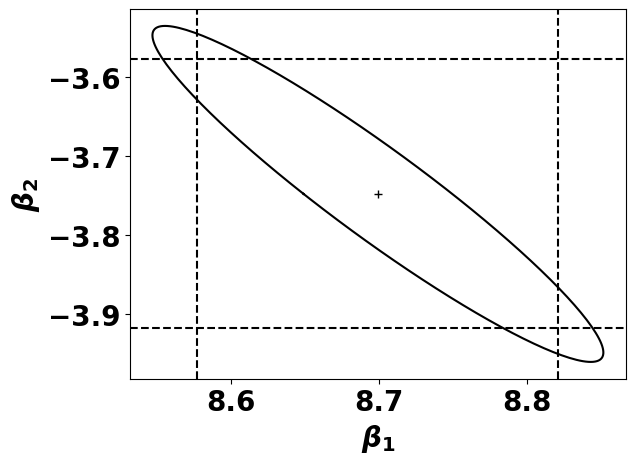

In [6]:
_,ax = plt.subplots()
ax.plot(betapts[:,0], betapts[:,1], color='black')
ax.plot(betas_qr[0], betas_qr[1], '+', color='black')
ax.axvline(x=marginal_betas[0][0], linestyle='--', color='black')
ax.axvline(x=marginal_betas[0][1], linestyle='--', color='black')
ax.axhline(y=marginal_betas[1][0], linestyle='--', color='black')
ax.axhline(y=marginal_betas[1][1], linestyle='--', color='black')

print(np.min(betapts[:,0]))
ax.set_xlabel(r"$\beta_1$")
ax.set_ylabel(r"$\beta_2$")
plt.savefig("../figs/confidenceregion.png", bbox_inches="tight")

6.41 <= y_0 <= 6.50
6.40 <= y_1 <= 6.48
5.50 <= y_2 <= 5.60
4.85 <= y_3 <= 4.98
5.26 <= y_4 <= 5.37
5.28 <= y_5 <= 5.39
5.73 <= y_6 <= 5.82
6.35 <= y_7 <= 6.43
6.29 <= y_8 <= 6.38
4.80 <= y_9 <= 4.94
4.46 <= y_10 <= 4.62
5.06 <= y_11 <= 5.18


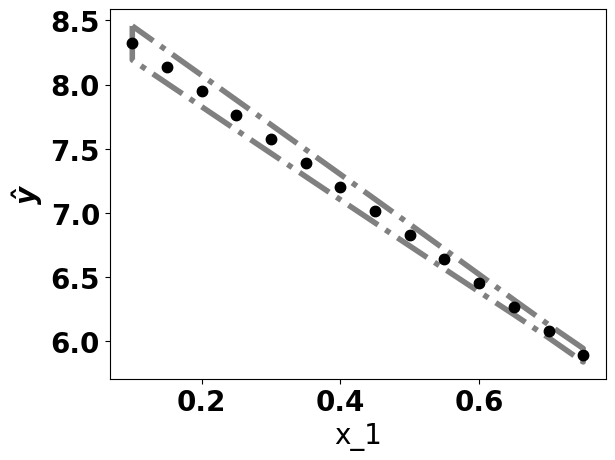

In [11]:
# Prediction Confidence Interval
for i, y_i in enumerate(reg.predict(x)):
    v = np.sqrt(s2 * (x[i,:].T @ np.linalg.inv(x.T @ x) @ x[i,:]))*np.abs(t.ppf(1 - alpha/2, dof))
    print(f"{y_i - v:0.2f} <= y_{i} <= {y_i + v:0.2f}")
    if i > 10:
        break

xi = np.arange(0.1, 0.8, 0.05)
xi = np.vstack([np.ones(xi.shape[0]), xi]).T

yy = np.max(np.abs(np.sqrt(xi @ np.linalg.inv(x.T @ x) @ xi.T) * np.sqrt(s2*p * f.ppf(1-alpha, p, n-p))), axis=1)
y_h = xi @ betas_qr

_,ax = plt.subplots()
ax.plot(xi[:,1], y_h, '.', color='black', markersize=15)
ax.fill_between(xi[:,1], y_h - yy, y_h + yy, edgecolor='gray', facecolor='white', alpha=1,
    linewidth=4, linestyle='dashdot', antialiased=True)
ax.set_xlabel('x_1')
ax.set_ylabel(r'$\hat{y}$')
plt.savefig('../figs/predband.png', bbox_inches="tight")

In [8]:
def chol(x):
  m = x.shape[0]
  chol = np.zeros((m, m))
  for j in range(m):
    for i in range(j,m):
      delta = x[i,j] - np.dot(chol[i,:j], chol[j,:j])
      chol[i,j] = np.sqrt(delta) if i==j else delta/chol[j,j]
  return chol
def inv(x):
  l = chol(x)
  tmp = l.copy()
  m = x.shape[0]
  for i in range(m):
    tmp[i,i] = 1/l[i,i]
    for j in range(i):
      tot = np.dot(tmp[i, j:i], tmp[j, j:i])
      tmp[j,i] = -np.dot(tmp[i, j:i], tmp[j, j:i])/l[i,i]
      tmp[i,j] = 0
  x_inv = np.zeros((m,m))
  for i in range(m):
    dii = np.dot(tmp[i,i:], tmp[i,i:])
    x_inv[i,i] = dii
    for j in range(i+1, m):
      dij = np.dot(tmp[i, j:], tmp[j, j:])
      x_inv[i,j] = dij
      x_inv[j,i] = dij
  return x_inv
    
inv(x.T @ x)@ x.T @ y

array([ 8.6992847 , -3.74766658])

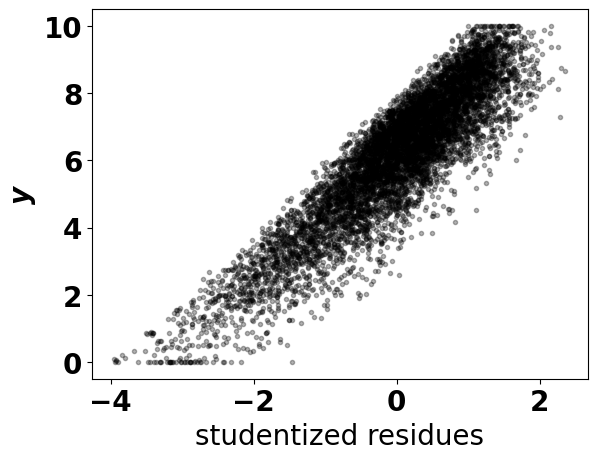

In [9]:
std_res = (y - reg.predict(x))/np.sqrt(s2*np.diag(1 - q1 @ q1.T))

_,ax = plt.subplots()
plt.plot(std_res, y, '.', color='black', alpha=0.3)
ax.set_xlabel('studentized residues')
ax.set_ylabel(r'$y$')
plt.savefig('../figs/stdres.png', bbox_inches="tight")